### Imports
Import packages and load model parameters (uncertainties, levers, etc.)

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle

In [2]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

1.4.2
2.8


In [3]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation


def sum_over(*args):
    return sum(args)

In [4]:
# Enable logging
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

**Problem formulation**
Important cell below, here you can choose the problem formulation number, between 0-5
each problem formulation has its own list of outcomes

In [5]:
used_problem_formulation = 2

dike_model, planning_steps = get_model_for_problem_formulation(used_problem_formulation)

In [6]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
CategoricalParameter('A.1_Brate', [0, 1, 2])
CategoricalParameter('A.2_Brate', [0, 1, 2])
CategoricalParameter('A.3_Brate', [0, 1, 2])
CategoricalParameter('A.4_Brate', [0, 1, 2])
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [7]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

In [8]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage 0', 'A.2_Expected Annual Damage 0', 'A.3_Expected Annual Damage 0', 'A.4_Expected Annual Damage 0', 'A.5_Expected Annual Damage 0', 'A.1_Expected Annual Damage 1', 'A.2_Expected Annual Damage 1', 'A.3_Expected Annual Damage 1', 'A.4_Expected Annual Damage 1', 'A.5_Expected Annual Damage 1', 'A.1_Expected Annual Damage 2', 'A.2_Expected Annual Damage 2', 'A.3_Expected Annual Damage 2', 'A.4_Expected Annual Damage 2', 'A.5_Expected Annual Damage 2'), function=<function sum_over at 0x00000165ED2CADC0>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs 0', 'A.2_Dike Investment Costs 0', 'A.3_Dike Investment Costs 0', 'A.4_Dike Investment Costs 0', 'A.5_Dike Investment Costs 0', 'A.1_Dike Investment Costs 1', 'A.2_Dike Investment Costs 1', 'A.3_Dike Investment Costs 1', 'A.4_Dike Investment Costs 1', 'A.5_Dike Investment Costs 1', 'A.1_Dike Investment Costs 2', 'A.2_Dike Investm

### Policy formulations
In the following cells the wanted policies can be adjusted

In [9]:
# Create a function which sets everything to 0 by default
def get_0_dict():
    return {l.name: 0 for l in dike_model.levers}

# Creates a Policy object from a dict and a (optional) name
def create_policy(dict1, name=None):
    return Policy(f"Policy_{name}", **dict(get_0_dict(), **dict1))

In [10]:
get_0_dict()

{'0_RfR 0': 0,
 '0_RfR 1': 0,
 '0_RfR 2': 0,
 '1_RfR 0': 0,
 '1_RfR 1': 0,
 '1_RfR 2': 0,
 '2_RfR 0': 0,
 '2_RfR 1': 0,
 '2_RfR 2': 0,
 '3_RfR 0': 0,
 '3_RfR 1': 0,
 '3_RfR 2': 0,
 '4_RfR 0': 0,
 '4_RfR 1': 0,
 '4_RfR 2': 0,
 'EWS_DaysToThreat': 0,
 'A.1_DikeIncrease 0': 0,
 'A.1_DikeIncrease 1': 0,
 'A.1_DikeIncrease 2': 0,
 'A.2_DikeIncrease 0': 0,
 'A.2_DikeIncrease 1': 0,
 'A.2_DikeIncrease 2': 0,
 'A.3_DikeIncrease 0': 0,
 'A.3_DikeIncrease 1': 0,
 'A.3_DikeIncrease 2': 0,
 'A.4_DikeIncrease 0': 0,
 'A.4_DikeIncrease 1': 0,
 'A.4_DikeIncrease 2': 0,
 'A.5_DikeIncrease 0': 0,
 'A.5_DikeIncrease 1': 0,
 'A.5_DikeIncrease 2': 0}

In the following policies formulations:
- `RfR` says if the Room for River projects are enabled (projects `0` to `5`). The first number indicated the project, the second (after `RfR`) if in which time step the measure it taken (currently `0` to `2`). The value can be either `0` (not enabled) or `1` (enabled).
- `A.1` to `A.5` are the different dikes. `A.3` is the dike ring around Zutphen. The number after `DikeIncrease` is again the timestep, the value assigned to the thing the heightening in decimeters.
- Early Warning Systems can also be enabled, with `EWS_DaysToThreat`, which specifies the early warning time in days.

See the implementation in problem_formulation.py (starting from line 35) for more details.

In [11]:
pol_list = []
#pol_list.append(create_policy({}, name="Zero"))

for dm in [0, 5, 10]:
    for location in [0, 1, 2, 3, 4]:
        for ews_days in [2, 4]:
            pol_list.append(create_policy({"A.3_DikeIncrease 0": dm, f"{location}_RfR 0": 1, "EWS_DaysToThreat": ews_days},
                                          name=f"Dike_{dm}dm_RfR_{location}_EWS_{ews_days}d"))


### Run the model (or load the data)
In the next cell the model is ran (if `use_pickle1 = False`) and the new results data is saved, or, if `use_pickle1 = True`, the saved results data is loaded.

In [12]:
# True, use results in pickle file; False, run MultiprocessingEvaluator
use_pickle1 = True

if use_pickle1:
    with open('data/formulation_results.pickle', 'rb') as filehandler:
        results = pickle.load(filehandler)

else:
    # pass the policies list to EMA workbench experiment runs
    n_scenarios = 10
    with MultiprocessingEvaluator(dike_model, n_processes=3) as evaluator:
        results = evaluator.perform_experiments(n_scenarios, pol_list)

    # Save results in Pickle file
    with open('data/formulation_results.pickle', 'wb') as filehandler:
        pickle.dump(results, filehandler)

### Process the results
In this section a dataframe is generated with all the outcomes data, and aggegrated to mean, min, max and quantiles values for each policy.

In [13]:
# Create a dataframe from outcomes, and add the policy column to it
exp, out = results
df = pd.DataFrame(out)
df["Total Costs"] = df[["Dike Investment Costs", "RfR Investment Costs", "Evacuation Costs"]].sum(axis=1)
df["Cost plus Damage"] = df["Total Costs"] + df["Expected Annual Damage"]
df["policy"] = pd.DataFrame(exp)["policy"]
df

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Costs,Cost plus Damage,policy
0,3.113088e+09,9221120237041090560,NaN,NaN,NaN,9.221120e+18,9.221120e+18,Policy_No Action
1,3.728411e+09,0,0.0,0.000000,4.246190,0.000000e+00,3.728411e+09,Policy_No Action
2,2.222778e+08,0,0.0,0.000000,0.156073,0.000000e+00,2.222778e+08,Policy_No Action
3,2.620957e+09,0,0.0,0.000000,2.046359,0.000000e+00,2.620957e+09,Policy_No Action
4,8.903152e+08,0,0.0,0.000000,0.895560,0.000000e+00,8.903152e+08,Policy_No Action
...,...,...,...,...,...,...,...,...
7995,1.700329e+08,0,710400000.0,10020.952960,0.019512,7.104100e+08,8.804429e+08,Policy_Only all dikes heightened
7996,1.845536e+09,0,710400000.0,122787.662537,0.424540,7.105228e+08,2.556059e+09,Policy_Only all dikes heightened
7997,1.666137e+08,0,710400000.0,8157.811091,0.035244,7.104082e+08,8.770218e+08,Policy_Only all dikes heightened
7998,1.919715e+09,0,710400000.0,111607.860007,0.412170,7.105116e+08,2.630227e+09,Policy_Only all dikes heightened


In [14]:
# Define two functions to get the 5th and 95th quantiles
def q05(x):
    return x.quantile(0.05)

def q95(x):
    return x.quantile(0.95)

In [15]:
# Create a Pandas GroupBy object
group_df = df.groupby(by="policy")

# Create a list of statistical functions which are used
agg_par = ["mean", "min", "max", q05, q95]

# Create a dictionary with what outcome values are aggegrated with which functions
agg_dict = {
    "Expected Number of Deaths": agg_par,
    "Expected Annual Damage": agg_par,
    "Total Costs": "mean",
    "Cost plus Damage": agg_par,
}
# Create new dataframe with the aggegrated data per policy
TCA_df = group_df.agg(agg_dict)
TCA_df

Expected Number of Deaths            \
                                                          mean       min   
policy                                                                     
Policy_All                                            0.716557  0.008326   
Policy_No Action                                      1.754730  0.060397   
Policy_Only all dikes heightened                      0.085987  0.000999   
Policy_Only all rfr executed                          0.085987  0.000999   
Policy_Rural rfr, urban dike                          0.034640  0.000360   
Policy_Upstream dike, downstream rfr                  0.013295  0.000000   
Policy_Upstream rfr, downstream dike                  0.094504  0.000000   
Policy_Urban rfr, rural dike                          0.092731  0.001273   

                                                                    \
                                           max       q05       q95   
policy                                                               
Policy_All                            5.704533  0.048069  3.382275   
Policy_No Action                      6.115868  0.172270  4.063983   
Policy_Only all dikes heightened      0.684544  0.005768  0.405873   
Policy_Only all rfr executed          0.684544  0.005768  0.405873   
Policy_Rural rfr, urban dike          0.305634  0.001478  0.205470   
Policy_Upstream dike, downstream rfr  0.118425  0.000383  0.057839   
Policy_Upstream rfr, downstream dike  0.695529  0.003342  0.414569   
Policy_Urban rfr, rural dike          0.421853  0.009464  0.408698   

                                     Expected Annual Damage                \
                                                       mean           min   
policy                                                                      
Policy_All                                     6.302996e+08  1.035773e+07   
Policy_No Action                               1.835691e+09  4.880862e+07   
Policy_Only all dikes heightened               6.302996e+08  1.035773e+07   
Policy_Only all rfr executed                   6.302996e+08  1.035773e+07   
Policy_Rural rfr, urban dike                   3.760620e+08  4.087944e+06   
Policy_Upstream dike, downstream rfr           1.338174e+08  0.000000e+00   
Policy_Upstream rfr, downstream dike           6.368085e+08  0.000000e+00   
Policy_Urban rfr, rural dike                   5.404297e+08  5.181746e+06   

                                                                  \
                                               max           q05   
policy                                                             
Policy_All                            5.131129e+09  4.864650e+07   
Policy_No Action                      7.490168e+09  1.747817e+08   
Policy_Only all dikes heightened      5.131129e+09  4.864650e+07   
Policy_Only all rfr executed          5.131129e+09  4.864650e+07   
Policy_Rural rfr, urban dike          4.559443e+09  1.454155e+07   
Policy_Upstream dike, downstream rfr  1.539135e+09  5.584089e+06   
Policy_Upstream rfr, downstream dike  5.233069e+09  2.334624e+07   
Policy_Urban rfr, rural dike          2.785620e+09  5.036554e+07   

                                                     Total Costs  \
                                               q95          mean   
policy                                                             
Policy_All                            2.415204e+09  7.104000e+08   
Policy_No Action                      3.865357e+09  9.221120e+15   
Policy_Only all dikes heightened      2.415204e+09  7.104290e+08   
Policy_Only all rfr executed          2.415204e+09  7.104290e+08   
Policy_Rural rfr, urban dike          2.140844e+09  5.260063e+08   
Policy_Upstream dike, downstream rfr  5.225911e+08  6.161573e+08   
Policy_Upstream rfr, downstream dike  2.470618e+09  4.116887e+08   
Policy_Urban rfr, rural dike          1.936291e+09  5.018486e+08   

                                     Cost plus Damage                \
            

In [16]:
# Save the aggegrated data to a CSV file
TCA_df.to_csv(f"results/TCA_results_pf{used_problem_formulation}.csv")

In [17]:
TCA_df.columns

MultiIndex([('Expected Number of Deaths', 'mean'),
            ('Expected Number of Deaths',  'min'),
            ('Expected Number of Deaths',  'max'),
            ('Expected Number of Deaths',  'q05'),
            ('Expected Number of Deaths',  'q95'),
            (   'Expected Annual Damage', 'mean'),
            (   'Expected Annual Damage',  'min'),
            (   'Expected Annual Damage',  'max'),
            (   'Expected Annual Damage',  'q05'),
            (   'Expected Annual Damage',  'q95'),
            (              'Total Costs', 'mean'),
            (         'Cost plus Damage', 'mean'),
            (         'Cost plus Damage',  'min'),
            (         'Cost plus Damage',  'max'),
            (         'Cost plus Damage',  'q05'),
            (         'Cost plus Damage',  'q95')],
           )

### Plots

TODO: Make make some nice Seaborn plots?

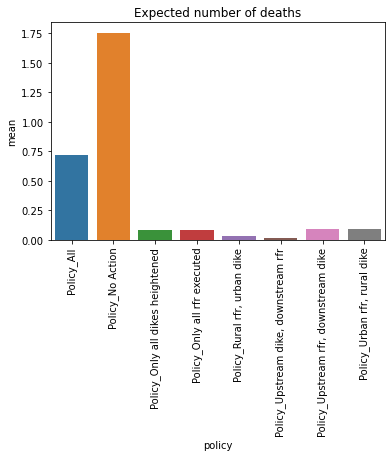

<Figure size 432x288 with 0 Axes>

In [18]:
#TCA_df["Expected Number of Deaths"]["mean"].plot.bar()
ND = sns.barplot(x= TCA_df.index , y = TCA_df["Expected Number of Deaths"]["mean"], data = TCA_df)
ND.set(title='Expected number of deaths')
#ND.fig.suptitle('Expected number of deaths')
plt.xticks(rotation=90)
plt.show()
plt.savefig('images/Debate/number of deaths.png',dpi=300,format="png")

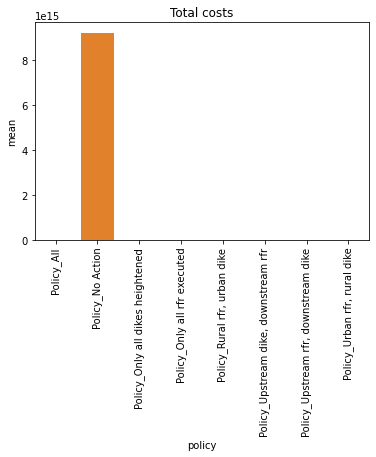

<Figure size 432x288 with 0 Axes>

In [19]:
#TCA_df["Total Costs"]["mean"].plot.bar()
TC = sns.barplot(x= TCA_df.index , y = TCA_df["Total Costs"]["mean"], data = TCA_df)
TC.set(title='Total costs')
plt.xticks(rotation=90)
plt.show()
plt.savefig('images/Debate/total costs.png',dpi=300,format="png")

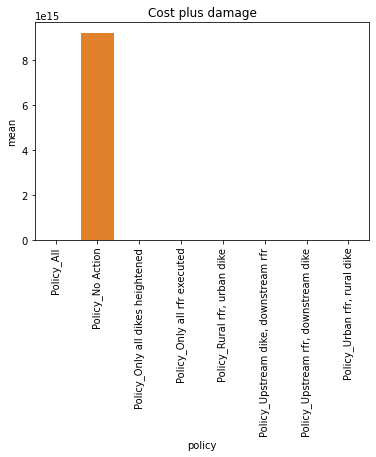

<Figure size 432x288 with 0 Axes>

In [20]:
#TCA_df["Cost plus Damage"]["mean"].plot.bar()
CpD = sns.barplot(x= TCA_df.index , y = TCA_df["Cost plus Damage"]["mean"], data = TCA_df)
CpD.set(title='Cost plus damage')
plt.xticks(rotation=90)
plt.show()
plt.savefig('images/Debate/cost plus damage.png',dpi=300,format="png")